In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from tools import *
from h5_tools import *
from fitting_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
# import pandas as pd
import glob

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.5", "font.size": 14})
plt.rcParams['legend.title_fontsize'] = 'small'

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

In [4]:
# T_msd = np.array([250., 240., 230., 220., 210.])
# D_msd = np.array([[0.12840888, 0.05475286, 0.01819226, 0.00643633, 0.00220065],
#                   [1.12360558e-02, 1.89669054e-03, 3.34886878e-04, 7.65708457e-05, 2.47397343e-05]]).T

In [5]:
conc_v_w_mol()


    c (mg/ml) 	 v% 	 w% 	 mol% 	 
    102         48.9 	 54.8 	 19.2
    135 	50.6 	 56.4 	 20.2
    314 	60.5 	 65.9 	 27.5
    SU13        55.0     60.7    23.2
    DLS         44.2     50.0    16.4
    


# Select runs

In [6]:
# c1 temps 250-210 K full beam
runnames = ['ferritin_conc_gly_50_6']
datasetnumbers = [2,3,4,5,6]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6']

In [7]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(float(info['Temperature, K']))
    
    else:
        print(filename, "\nFile exists: False")
T = np.array(T)

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0002.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0002
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 250K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0004
Temp

# Brownian motion $q$-dependence

In [8]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 12, 80)


In [9]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')

[0.04026906 0.02195725 0.0134452  0.00969675 0.00693302 0.0051073
 0.00400939 0.0034825  0.00239275 0.00199161] [0.108 0.148 0.188 0.228 0.268 0.308 0.348 0.388 0.428 0.468]


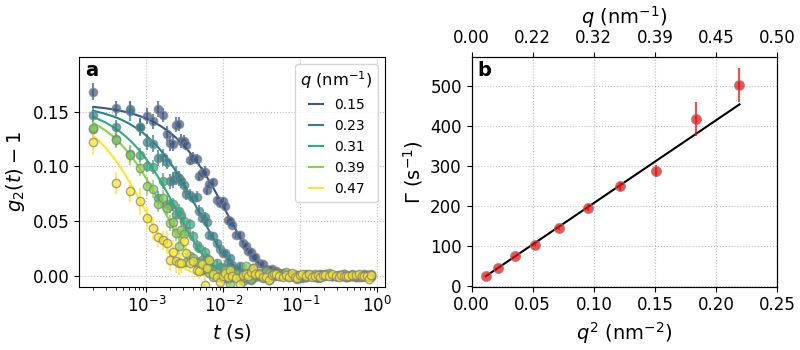

In [10]:
f, (a1,a3) = plt.subplots(1,2, figsize=(8,3.5), constrained_layout=True)
ax2 = a3.twiny()


col = plt.cm.viridis(np.linspace(0,1,len(qv)))
qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 2, len(qv), 1

i = 4
taus, dtaus = [], []

for q in range(qv_min, qv_max, qstep):
    base = np.average(g2s[i,q,-15:])
    popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
    taus.append(popt[1])
    dtaus.append(perr[1])
    
    if q%2 == 1:
        a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[q], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
        a1.plot(xc, curve, c=col[q], ls='-', alpha=1, label=f'{qv[q]:.2f}')

qs = qv[qv_min:qv_max:qstep]
taus, dtaus = np.asarray(taus), np.asarray(dtaus)
cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])
print(taus, qs)
popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])

a3.plot(xc, curve, c='k')#, label=f'{Ds[0,i]:.2e}')
a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c='r', ls='', marker='o', mec='gray', alpha=0.7, ms=7)

a1.legend(title=r'$q$ (nm$^{-1}$)', fontsize=10, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(t)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.2)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
a3.set_xticks(np.arange(0,0.26,0.05))
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)
a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
a3.text(0.02, 0.92, 'b', fontweight='bold', transform=a3.transAxes)

# top axis
ax2.set_xlim(a3.get_xlim())
ax2.set_xticks(np.arange(0,0.26,0.05))
ax2.set_xticklabels([f"{x:.2f}" for x in np.sqrt(np.arange(0,0.26,0.05))])
ax2.set_xlabel('$q$ (nm$^{-1}$)')
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=10)

# plt.savefig('../06-figs/g2s_q-dep.png', dpi=300)

# Fig 1 - g2s

In [11]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 12, 80)


q=0.11 nm$^{-1}$ ferritin_conc_gly_50_6, Transm 100%


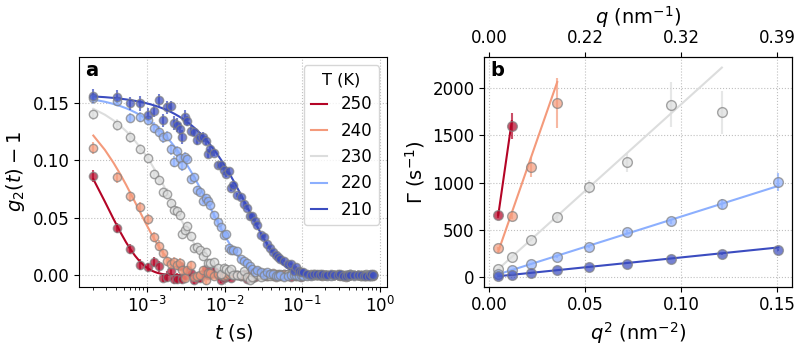

In [12]:
f, (a1,a3) = plt.subplots(1,2, figsize=(8,3.5), constrained_layout=True)
ax2 = a3.twiny()

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 1, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            # a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=1, label=f'{T[i]:.0f}')
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])

    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a3.plot(xc, curve, c=col[i], label=f'{Ds[0,i]:.2e}')
    # a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

a1.legend(title=r'T (K)', fontsize=12, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
print(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$", f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(t)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.19)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
# a3.set_xscale('log')
# a3.set_yscale('log')
a3.set_xticks(np.arange(0,0.16,0.05))
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)
a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
a3.text(0.02, 0.92, 'b', fontweight='bold', transform=a3.transAxes)

# top axis
ax2.set_xlim(a3.get_xlim())
ax2.set_xticks(np.arange(0,0.16,0.05))
ax2.set_xticklabels([f"{x:.2f}" for x in np.sqrt(np.arange(0,0.16,0.05))])
ax2.set_xlabel('$q$ (nm$^{-1}$)')
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=10)

# plt.savefig('../06-figs/g2s.png', dpi=300)

# Fig 2 - diffusion coefficient

### Arrhenius

In [13]:
def get_diff_coeff_library(filename='../03-source/diffusion_coefficient'):
    """Return dataframe with diffusion coefficients from the experimental data
    """
    df = pd.read_pickle(filename)
    df['temperature'] = df['temperature'].replace(243, 240)
    df['transmission'] = df['transmission'].str.replace('%', '')
    df['transmission'] = df['transmission'].str.replace('nan', '100')
    df['transmission'] = df['transmission'].str.replace('~', '')
    df['transmission'] = df['transmission'].astype(float)
    
    return df

In [14]:
df2 = get_diff_coeff_library()

In [15]:
# load dls data
# DLS = load_npz_data('../03-source/DLS_diff_coeff.npz') # D in m^2/s, T in K
# DLS = load_npz_data('../03-source/dls_diluted.npz') # D in m^2/s, T in K
# DLS['D'] = DLS['D']*1e12
# DLS['dD'] = DLS['dD']*1e12

# SU13 = load_npz_data('../03-source/dls_su13.npz') # D in m^2/s, T in K
# SU13['D'] = SU13['D']*1e12

SU13_3 = load_npz_data('../03-source/dls_su13_3.npz') # D in nm^2/us, T in K
SU_55v = load_npz_data('../03-source/dls_dil_55v.npz') # D in nm^2/us, T in K
c1_dls = load_npz_data('../03-source/dls_c1_19mol.npz') # D in nm^2/us, T in K
# SU13_3['D'] = SU13_3['D']*1e12

In [16]:
Dc1 = np.load('../03-source/D_c1_240611.npz')
Dc1.files

['D', 'dD', 'T']

In [17]:
D_c1 = df2[(df2['c']=='c1') & (df2['transmission']==100)].sort_values(by='temperature')
D_c1 = D_c1.drop(10)
D_c2 = df2[(df2['c']=='c2') & (df2['transmission']==100)].sort_values(by='temperature')
D_c3 = df2[(df2['c']=='c3') & (df2['transmission']==100)].sort_values(by='temperature')

In [18]:
labs = ['102', '135', '314']

**All data here**

In [19]:
f_19 = np.load("../03-source/viscosity_fit_19mol.npz")
f_23 = np.load("../03-source/viscosity_fit_23mol.npz")
f_19.files

['T_high', 'eta_high', 'T_low', 'eta_low']

In [20]:
eta_19 = np.concatenate([f_19['eta_low'], f_19['eta_high']])
T_19 = np.concatenate([f_19['T_low'], f_19['T_high']])
T_19

array([200., 210., 220., 230., 240., 250., 260., 263., 264., 268., 273.,
       278., 283., 288., 293., 298.])

VFT: T0=2088.034402892527


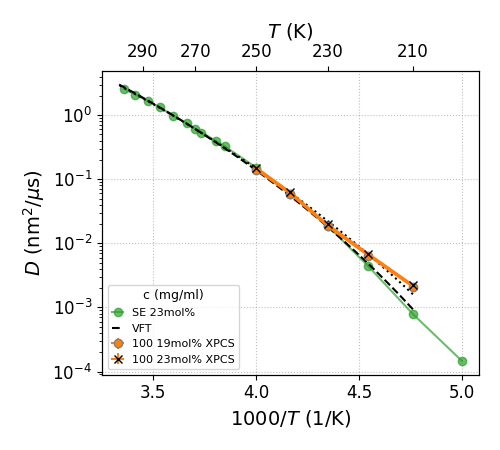

In [21]:
f, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)
ax2 = ax.twiny()

scale = 1e3
cols = plt.cm.copper_r(np.linspace(0,1,3))

Kbb = 1.3806e-23 # J/K
Rh = 7.3e-9
Na = 6.02214076e23 
new_T = np.linspace(210,300,100)

# xpcs c1 in 19 mol%
ax.errorbar(scale/Dc1['T'], Dc1['D'], Dc1['dD'], marker='o', c='C1',  mec='gray', label='100 19mol% XPCS')
SE = Kbb*f_23['T'] / (6*np.pi*Rh*f_23['eta'])

ax.plot(scale/f_23['T'], SE*1e12, marker='o', c='C2', alpha=0.7, label='SE 23mol%')
rescale = SE[5]*1e12 / Dc1['D'][0]
ax.errorbar(scale/Dc1['T'], Dc1['D'] * rescale, Dc1['dD'] * rescale, marker='x', c='C1',  mec='k', label='100 23mol% XPCS')

# # VFT fit NP
popt_NP,xc_NP,curve_NP,perr_NP = fit(VFT, f_23['T'],  SE*1e12, sigma=SE*1e12*0.01, p0=[100, -1., 10], bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)
print(f'VFT: T0={popt[-1]}')
ax.plot(scale/new_T, VFT(new_T, *popt_NP), ls='--', c='k', label='VFT')


# # VFT fit NP + XPCS
limm = 10

fit_x = np.concatenate([f_23['T'][-11:], Dc1['T']])
fit_y = np.concatenate([SE[-11:]*1e12,  Dc1['D']])
fit_dy = np.concatenate([SE[-11:]*1e12*0.01, Dc1['dD']])
popt_p,xc_p,curve_p,perr_p = fit(VFT, fit_x, fit_y, sigma=fit_dy, p0=[100, -1., 10], bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)
ax.plot(scale/new_T, VFT(new_T, *popt_p), ls=':', c='k')#, label='VFT XPCS')

# -- plot setting
ax.set_xlabel(f'${scale:.0f}/T$ (1/K)')
ax.set_ylabel('$D$ (nm$^{{2}}$/${{\mu}}$s)')
ax.legend(fontsize=8, handlelength=1, loc='lower left', title='c (mg/ml)', title_fontsize=9) #, bbox_to_anchor=[1,1])
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(270,210)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/np.arange(210,300,20))
ax2.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax2.set_xlabel('$T$ (K)', fontsize=14)
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)

**D vs $\eta/T$**

In [22]:
# def eta_vs_T(T):
#     return [f_19['eta_low'][f_19['T_low'] == T][0] for t in Dc1['T'] ]

# def SE_fract(T, xi):
#     """ Fractional Stokes-Einstein
#     https://journals-aps-org.ezp.sub.su.se/prl/pdf/10.1103/PhysRevLett.97.055901
#     """
#     kb = 1.380649e-23 #m2 kg s-2 K-1 = J/K
#     # etas = f_23['eta']
#     # etas = eta_vs_T(T) #
#     etas = np.array([f_19['eta_low'][f_19['T_low'] == t][0] for t in Dc1['T'] ]) #Ns/m
    
#     print(etas)
#     Rh = 7.3e-9
#     return (kb * T / (6*np.pi * Rh * etas) *1e12)


$ D = \frac{k_B T}{6\pi\eta R_h} $

In [23]:
R = 7.3e-9 # nm
eta = Kbb*T / (6*np.pi*Ds[0,:]*R)
eta[T==250]

array([1.77252932e-13])

In [24]:
# from ID10 LLT NP viscosity values from XPCS
f_NP = np.load("../03-source/viscosity_NP.npz") # 23 mol% =  (50 w% = 44 v%) or (60 w% = 55 v%)
# plt.plot(f['T_np'], f['eta_np'], label='NP 23 mol%', c='C2', marker='o')
f_NP.files

['T_np', 'eta_np', 'T_gly', 'eta_gly']

### $D\cdot\eta(T)$

**Use eta from NP**

In [25]:
# constants
Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
scale = 1e3
R = 7.3e-9 # nm
# T_sel = 260

In [26]:
NP = pd.DataFrame(list(zip(f_NP['T_np'], f_NP['eta_np'])), columns=['T', 'eta'])
NP

,T,eta
0,200,85.549575
1,200,119.023232
2,210,23.221277
3,220,4.388098
4,230,1.072047
5,240,0.351025
6,250,0.143399
7,260,0.069314
8,270,0.038354


In [27]:
f_19 = np.load("../03-source/viscosity_fit_19mol.npz")
f_23 = np.load("../03-source/viscosity_fit_23mol.npz")
f_23.files

['T', 'eta']

In [28]:
f_19['T_high']

array([263, 264, 268, 273, 278, 283, 288, 293, 298])

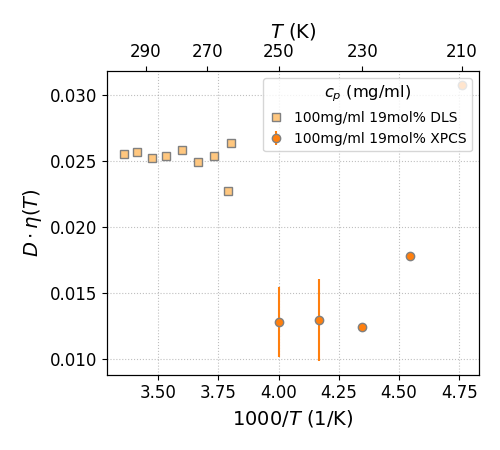

In [29]:
f, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)
ax2 = ax.twiny()
cols = plt.cm.copper_r(np.linspace(0,1,3))

# viscosity from rescaling 23mol5 to 19mol%
norm_etas_dls_new = [f_19['eta_high'][f_19['T_high'] == t][0] for t in c1_dls['T'] ]

# new dls c1 in 19mol%
# ax.errorbar(scale/c1_dls['T'], c1_dls['D'], c=cols[0], ls='', marker='s', mec='gray',label=f'100 | 49% DLS') # 
ax.errorbar(scale/c1_dls['T'], c1_dls['D']*norm_etas_dls_new, c=cols[0], ls='', marker='s', mec='gray',label=f'100mg/ml 19mol% DLS') # 

# print(f"c1 dls: 100 | {-Ea2:.0f} DLS (49v%)")


# ax.errorbar(scale/c1_dls['T'], c1_dls['D'], c='C1', ls='', marker='s', mec='gray',label=f'100 19mol% DLS') # 

# xpcs c1 in 19 mol%
norm_etas_xpcs = [f_19['eta_low'][f_19['T_low'] == t][0] for t in Dc1['T'] ]
ax.errorbar(scale/Dc1['T'], Dc1['D'] * norm_etas_xpcs, Dc1['dD'], ls='', marker='o', c='C1',  mec='gray', label='100mg/ml 19mol% XPCS')

SE = Kbb*T_19 / (6*np.pi*Rh*eta_19)
# ax.plot(scale/T_19, SE*1e12 , marker='o', c='C2', alpha=0.7, label='SE 19mol%')


# -- plot settings
ax.set_xlabel(f'${scale:.0f}/T$ (1/K)')
ax.set_ylabel('$D\cdot\eta(T)$')
ax.legend(fontsize=10, handlelength=1, title='$c_p$ (mg/ml)')#, bbox_to_anchor=[1,1])
# ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(270,210)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/np.arange(210,300,20))
ax2.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax2.set_xlabel('$T$ (K)', fontsize=14)
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/diff_coeff_eta.png', dpi=300)

In [30]:
conc_v_w_mol()


    c (mg/ml) 	 v% 	 w% 	 mol% 	 
    102         48.9 	 54.8 	 19.2
    135 	50.6 	 56.4 	 20.2
    314 	60.5 	 65.9 	 27.5
    SU13        55.0     60.7    23.2
    DLS         44.2     50.0    16.4
    


### $D/D_0$

In [31]:
SU13_3['T']

array([263., 268., 273., 278., 283., 288., 293., 298.])

Mass fraction of mixture = [0.55180955 0.55164483 0.55101033 0.55027815 0.54964042 0.54913154
 0.54870002 0.54833156 0.54801928]
Volume fraction of mixture = 0.49


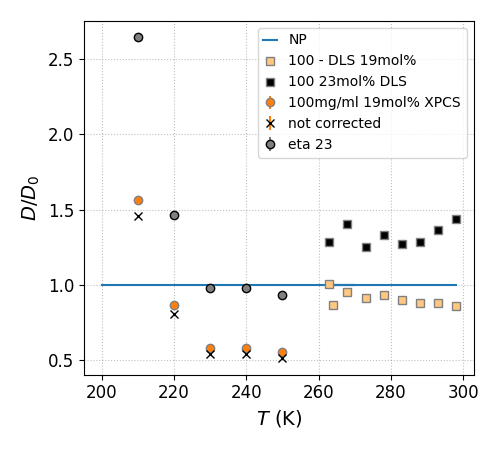

In [32]:
f, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)
cols = plt.cm.copper_r(np.linspace(0,1,3))

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9
# -- xpcs c1 in 19 mol%
# norm_etas_xpcs = np.array([f_19['eta_low'][f_19['T_low'] == t][0] for t in Dc1['T'] ])
# D0 = kb * Dc1['T'] / ( 6*np.pi * Rh * norm_etas_xpcs)*1e12
D = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])
D0_np = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])
ax.plot(f_23['T'],  D/D0_np, label='NP')
# ax.errorbar(Dc1['T'], Dc1['D'] / D0, Dc1['dD'], ls='', marker='o', c='C1',  mec='gray', label='100mg/ml 19mol% XPCS')

norm_etas_su13 = np.array([f_23['eta'][f_23['T'] == t][0] for t in SU13_3['T'] ])
D0su13 = kb * SU13_3['T'] / ( 6*np.pi * Rh * norm_etas_su13)*1e12

ax.errorbar(SU13_3['T'], SU13_3['D']/D0su13, c='k', ls='', marker='s', mec='gray',label=f'100 23mol% DLS') # 

# -- dls c1
etas_c1_dls = viscosity_glywater(np.array(c1_dls['T']) - 273, volume_percent=0.49)
etas_c1_dls2 = np.array([f_19['eta_high'][f_19['T_high'] == t][0] for  t in c1_dls['T']])

D0 = kb*c1_dls['T'] / ( 6*np.pi*Rh*etas_c1_dls)*1e12
ax.plot(c1_dls['T'], c1_dls['D'] / D0, c=cols[0], ls='', marker='s', mec='gray',label=f'100 - DLS 19mol%') # label='DLS dilute',

D00 = kb*c1_dls['T'] / ( 6*np.pi*Rh*etas_c1_dls2)*1e12
# ax.plot(c1_dls['T'], c1_dls['D'] / D00, c=cols[0], ls='', marker='x', mec='gray',label=f'100 - DLS 19mol%') # label='DLS dilute',

# ATTEMPTS
# ax.axhline(y=boh, ls='--', c='gray')

norm_boh = np.array([f_19['eta_low'][f_19['T_low'] == t][0] for t in Dc1['T'] ])
D0 = kb * Dc1['T'] / ( 6*np.pi * Rh * norm_boh )*1e12

ax.errorbar(Dc1['T'], Dc1['D'] * rescale / D0, Dc1['dD'], ls='', marker='o', c='C1',  mec='gray', label='100mg/ml 19mol% XPCS')
ax.errorbar(Dc1['T'], Dc1['D'] / D0, Dc1['dD'], ls='', marker='x', c='C1',  mec='k', label='not corrected')

norm_23 = np.array([f_23['eta'][f_23['T'] == t][0] for t in Dc1['T'] ])
D0_23 = kb * Dc1['T'] / ( 6*np.pi * Rh * norm_23 )*1e12
ax.errorbar(Dc1['T'], Dc1['D'] / D0_23, Dc1['dD'], ls='', marker='o', c='gray',  mec='k', label='eta 23')


# -- plot settings
ax.set_xlabel(f'$T$ (K)')
ax.set_ylabel('$D / D_0$')
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
# ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/diff_coeff_D0.png', dpi=300)0

## Viscosity

In [33]:
f = np.load("../03-source/viscosity_NP.npz") # 23 mol% = 50 w% = 44 v%
f_dls = np.load("../03-source/dls_NP_23mol.npz") # 23 mol% = 50 w% = 44 v%

el_to_remove = np.array([264])
f_dls_T = np.setdiff1d(f_dls['T'], el_to_remove)

f_dls_T_l = list(f_dls['T'])
f_dls_T_l.pop(1)
f_dls_T = np.array(f_dls_T_l)

f_dls_D_l = list(f_dls['D'])
f_dls_D_l.pop(1)
f_dls_D = np.array(f_dls_D_l)


f_dls_dD_l = list(f_dls['dD'])
f_dls_dD_l.pop(1)
f_dls_dD = np.array(f_dls_dD_l)


In [34]:
import scipy.interpolate

def log_interp1d(xx, yy, kind='linear'):

    result = np.where(yy > 0.0000000001, yy, -10)
    logy = np.log10(result, out=result, where=result > 0)

    logx = np.log10(xx)
    lin_interp = scipy.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))

    return log_interp


(0.01, 0.1)

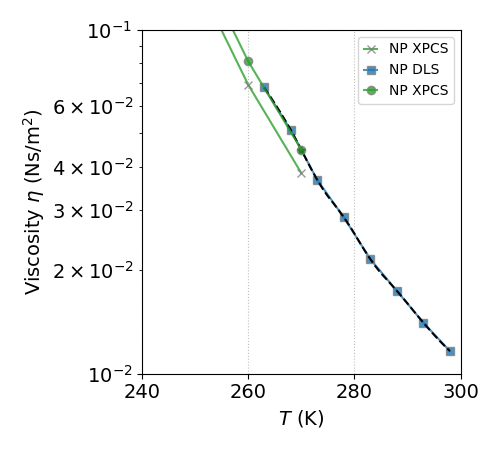

In [35]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9

ax.plot(f['T_np'][1:], f['eta_np'][1:], label='NP XPCS', c='C2', mec='gray', alpha=0.8, marker='x')

# DLS NP100nm 23m/ol%
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12)
ax.plot(f_dls_T, eta_dls, label='NP DLS', c='C0', mec='gray', alpha=0.8, marker='s')#, mfc='none')

# interpolate
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
ax.plot(new_x, lin_interp(new_x), 'k--')

mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]
plt.plot(new_x[mask], lin_interp(new_x)[mask], ls='', marker='*', c='k')

ax.plot(f['T_np'][1:], f['eta_np'][1:]*fact, label='NP XPCS', c='C2', mec='gray', alpha=0.8, marker='o')

# -- plot settings
ax.set_ylabel("Viscosity $\eta$ (Ns/m$^2$)")
ax.set_xlabel("$T$ (K)")
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
ax.set_xlim(240,300)
ax.set_ylim(0.01,0.1)

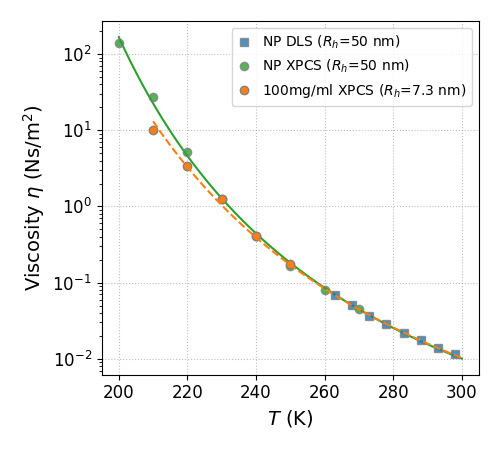

In [36]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9

# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

# DLS NP100nm 23m/ol%
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12)
ax.plot(f_dls_T, eta_dls, label='NP DLS ($R_h$=50 nm)', c='C0', mec='gray', ls='', alpha=0.8, marker='s')#, mfc='none')


ax.plot(f['T_np'][1:], f['eta_np'][1:]*fact, label='NP XPCS ($R_h$=50 nm)', ls='', c='C2', mec='gray', alpha=0.8, marker='o')



# -- xpcs c1 in 19 mol%
# norm_etas_xpcs = np.array([f_19['eta_low'][f_19['T_low'] == t][0] for t in Dc1['T'] ])
# D0 = kb * Dc1['T'] / ( 6*np.pi * Rh * norm_etas_xpcs)*1e12
D = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])
D0_np = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])

# ax.plot(f_23['T'],  D/D0_np, label='NP')
# ax.plot(f_23['T'],  D, label='NP')
eta_xpcs = kb * Dc1['T'] / (6*np.pi * Rh *  Dc1['D'])
# ax.errorbar(Dc1['T'], Dc1['D'] , Dc1['dD'], ls='', marker='o', c='C1',  mec='gray', label='100mg/ml 19mol% XPCS')
ax.plot(Dc1['T'], eta_xpcs*1e12,  marker='o', c='C1', ls='', mec='gray', label='100mg/ml XPCS ($R_h$=7.3 nm)', zorder=10)

new_TT = np.linspace(200,300,100)
eta_VFT_NP = kb * new_TT / (6*np.pi * Rh *  VFT(new_TT, *popt_NP))
ax.plot(new_TT, eta_VFT_NP*1e12, ls='-', c='C2', zorder=1, )#label=f'VFT $T_0$={popt_NP[-1]:.0f}K')

eta_VFT_p = kb * new_T / (6*np.pi * Rh *  VFT(new_T, *popt_p))
ax.plot(new_T, eta_VFT_p*1e12, ls='--', c='C1',  zorder=15)#, label=f'VFT $T_0$={popt_p[-1]:.0f}K',)

# -- plot settings
ax.set_ylabel("Viscosity $\eta$ (Ns/m$^2$)")
ax.set_xlabel("$T$ (K)")
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/viscosity_all.png', dpi=300)

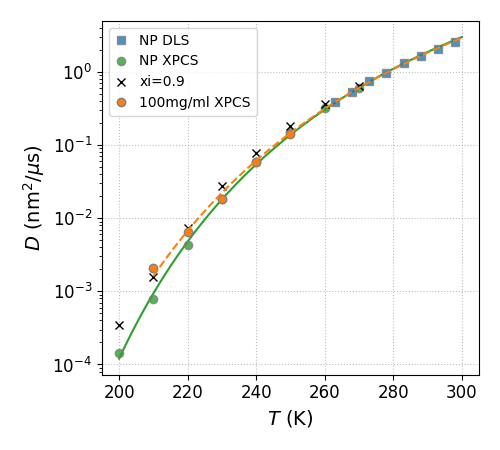

In [37]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9

# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

# DLS NP100nm 23m/ol%
ax.plot(f_dls_T, f_dls_D/Rh*Rh_NP, label='NP DLS', c='C0', mec='gray', ls='', alpha=0.8, marker='s')#, mfc='none')


SE = kb * f['T_np'] / (6*np.pi*f['eta_np']*fact*Rh)
ax.plot(f['T_np'][1:], SE[1:]*1e12, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o')
ax.plot(f['T_np'][1:], (SE[1:]*1e12)**0.9, label='xi=0.9', ls='', c='k', mec='k', marker='x')



# -- xpcs c1 in 19 mol%
D = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])
D0_np = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])

eta_xpcs = kb * Dc1['T'] / (6*np.pi * Rh *  Dc1['D'])
ax.plot(Dc1['T'], Dc1['D'],  marker='o', c='C1', ls='', mec='gray', label='100mg/ml XPCS', zorder=10)

new_TT = np.linspace(200,300,100)
ax.plot(new_TT,  VFT(new_TT, *popt_NP), ls='-', c='C2', zorder=1, )#label=f'VFT $T_0$={popt_NP[-1]:.0f}K')

ax.plot(new_T, VFT(new_T, *popt_p), ls='--', c='C1',  zorder=15)#, label=f'VFT $T_0$={popt_p[-1]:.0f}K',)

# -- plot settings
ax.set_ylabel("$D$ (nm$^{{2}}$/${{\mu}}$s)")
ax.set_xlabel("$T$ (K)")
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/D_vs_T.png', dpi=900)

**D vs $\eta/T$**

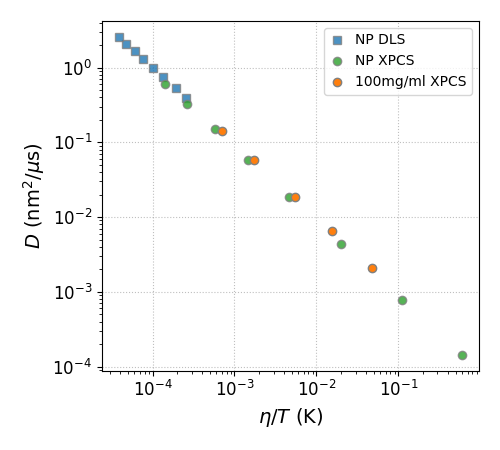

In [38]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9

# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

# DLS NP100nm 23m/ol%
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12)
ax.plot(eta_dls/f_dls_T, f_dls_D/Rh*Rh_NP, label='NP DLS', c='C0', mec='gray', ls='', alpha=0.8, marker='s')#, mfc='none')


# ax.plot(f_dls_T, eta_dls, label='NP DLS', c='C0', mec='gray', ls='', alpha=0.8, marker='s')#, mfc='none')
# ax.plot(f['T_np'][1:], f['eta_np'][1:]*fact, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o')

SE = kb * f['T_np'] / (6*np.pi*f['eta_np']*fact*Rh)
# etas = np.array([f_19['eta_low'][f_19['T_low'] == t][0] for t in f['T_np'] ]) #Ns/m
ax.plot(f['eta_np'][1:]/f['T_np'][1:], SE[1:]*1e12, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o')
# ax.plot(f['eta_np'][1:]/f['T_np'][1:], (SE[1:]*1e12)**0.9, label='xi=0.9', ls='', c='k', mec='k', marker='x')


# -- xpcs c1 in 19 mol%
D = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])
D0_np = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])

etas = np.array([f_19['eta_low'][f_19['T_low'] == t][0] for t in Dc1['T'] ]) #Ns/m
eta_xpcs = kb * Dc1['T'] / (6*np.pi * Rh *  Dc1['D'])
ax.plot(eta_xpcs*1e12/Dc1['T'], Dc1['D'],  marker='o', c='C1', ls='', mec='gray', label='100mg/ml XPCS', zorder=10)

# new_TT = np.linspace(200,300,100)
# ax.plot(new_TT,  VFT(new_TT, *popt_NP), ls='-', c='C2', zorder=1, )#label=f'VFT $T_0$={popt_NP[-1]:.0f}K')

# ax.plot(new_T, VFT(new_T, *popt_p), ls='--', c='C1',  zorder=15)#, label=f'VFT $T_0$={popt_p[-1]:.0f}K',)

# -- plot settings
ax.set_ylabel("$D$ (nm$^{{2}}$/${{\mu}}$s)")
ax.set_xlabel("$\eta/T$ (K)")
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/D_vs_T.png', dpi=900)

**$D\times R_H$**

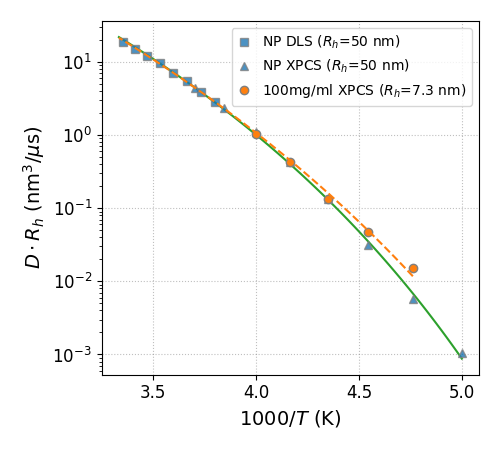

In [39]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9

# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

# DLS NP100nm 23m/ol%
ax.plot(scale/f_dls_T, f_dls_D*Rh_NP*1e9, label='NP DLS ($R_h$=50 nm)', c='C0', mec='gray', ls='', alpha=0.8, marker='s')#, mfc='none')


SE = kb * f['T_np'] / (6*np.pi*f['eta_np']*fact*Rh)
ax.plot(scale/f['T_np'][1:], SE[1:]*1e12*Rh*1e9, label='NP XPCS ($R_h$=50 nm)', ls='', c='C0', mec='gray', alpha=0.8, marker='^')
# ax.plot(f['T_np'][1:], (SE[1:]*1e12)**0.9, label='xi=0.9', ls='', c='k', mec='k', marker='x')



# -- xpcs c1 in 19 mol%
D = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])
D0_np = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])

eta_xpcs = kb * Dc1['T'] / (6*np.pi * Rh *  Dc1['D'])
ax.plot(scale/Dc1['T'], Dc1['D']*Rh*1e9,  marker='o', c='C1', ls='', mec='gray', label='100mg/ml XPCS ($R_h$=7.3 nm)', zorder=10)

new_TT = np.linspace(200,300,100)
ax.plot(scale/new_TT,  VFT(new_TT, *popt_NP)*Rh*1e9, ls='-', c='C2', zorder=1, )#label=f'VFT $T_0$={popt_NP[-1]:.0f}K')

ax.plot(scale/new_T, VFT(new_T, *popt_p)*Rh*1e9, ls='--', c='C1',  zorder=15)#, label=f'VFT $T_0$={popt_p[-1]:.0f}K',)

# -- plot settings
ax.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mu}}$s)")
ax.set_xlabel("$1000/T$ (K)")
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/D_vs_T.png', dpi=300)

**Other fits**

In [40]:
def linear_q(x,m,q):
    return m * x + q

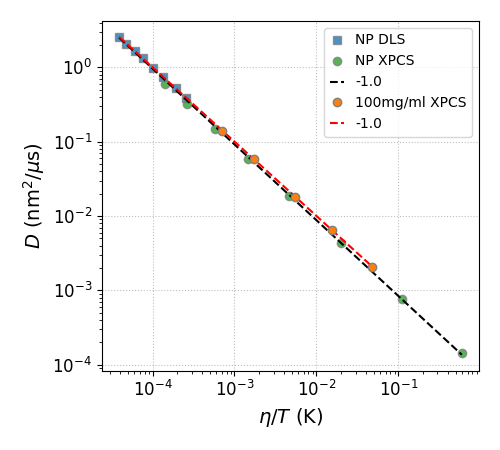

In [41]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9

# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

# DLS NP100nm 23m/ol%
x_NP = np.concatenate([eta_dls/f_dls_T, f['eta_np'][1:]/f['T_np'][1:]])
y_NP = np.concatenate([f_dls_D/Rh*Rh_NP, SE[1:]*1e12])

eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12)
ax.plot(eta_dls/f_dls_T, f_dls_D/Rh*Rh_NP, label='NP DLS', c='C0', mec='gray', ls='', alpha=0.8, marker='s')

SE = kb * f['T_np'] / (6*np.pi*f['eta_np']*fact*Rh)
ax.plot(f['eta_np'][1:]/f['T_np'][1:], SE[1:]*1e12, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o')

popt,xc,curve,perr = fit(linear_q, np.log(x_NP), np.log(y_NP), p0=[1.,1.])#, bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)
plt.plot(np.exp(xc), np.exp(curve), '--k', label=f'{popt[0]:.1f}')

# -- xpcs c1 in 19 mol%
D = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])
D0_np = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])

etas = np.array([f_19['eta_low'][f_19['T_low'] == t][0] for t in Dc1['T'] ]) #Ns/m
eta_xpcs = kb * Dc1['T'] / (6*np.pi * Rh *  Dc1['D'])
ax.plot(eta_xpcs*1e12/Dc1['T'], Dc1['D'],  marker='o', c='C1', ls='', mec='gray', label='100mg/ml XPCS', zorder=10)

x_pr = np.concatenate([eta_dls/f_dls_T, eta_xpcs*1e12/Dc1['T']])
y_pr = np.concatenate([f_dls_D/Rh*Rh_NP, Dc1['D']])
popt,xc,curve,perr = fit(linear_q, np.log(x_pr), np.log(y_pr), p0=[1.,1.])#, bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)

new_TT = np.linspace(200,300,100)
plt.plot(np.exp(xc), np.exp(curve), '--r', label=f'{popt[0]:.1f}')



# -- plot settings
ax.set_ylabel("$D$ (nm$^{{2}}$/${{\mu}}$s)")
ax.set_xlabel("$\eta/T$ (K)")
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/D_vs_T.png', dpi=900)

protein: -0.81, -26.861


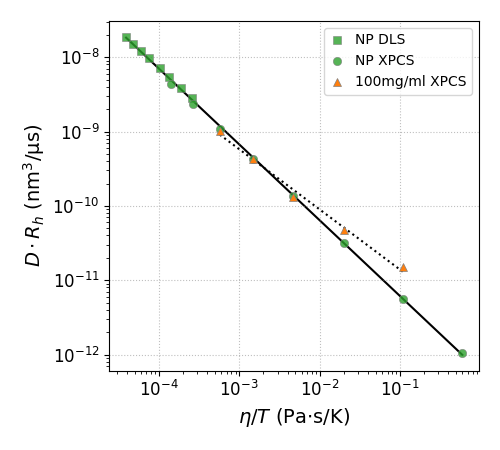

In [55]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9

# -- rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

# -- DLS NP100nm 23mol%
eta_dls = f_dls_T * kb / (6*np.pi * Rh_NP * f_dls_D*1e-12)
ax.plot(eta_dls/f_dls_T, f_dls_D * Rh_NP, label='NP DLS', c='C2', mec='gray', ls='', mew=.5, alpha=0.8, marker='s',zorder=2)

# -- NP XPCS 23 molt%
SE = kb * f['T_np'] / (6*np.pi * f['eta_np'] * Rh_NP * fact)
ax.plot(f['eta_np'][1:]/f['T_np'][1:], SE[1:]*1e12 * Rh_NP, label='NP XPCS', ls='', c='C2', mec='gray',mew=.5, alpha=0.8, marker='o',zorder=3)

# -- SE fit
x_NP = np.concatenate([eta_dls/f_dls_T, f['eta_np'][1:]/f['T_np'][1:]])
y_NP = np.concatenate([f_dls_D*Rh_NP, SE[1:]*1e12*Rh_NP])
popt2,xc2,curve2,perr2 = fit(linear_q, np.log(x_NP), np.log(y_NP), p0=[1.,1.])#, bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)
plt.plot(np.exp(xc2), np.exp(curve2), '-k', zorder=1) #label=f'{popt[0]:.3f}'
# print(f'NP: {popt[0]:.2f}, {popt[1]:.3f}')

# -- Protein XPCS c1 in 23 mol%
etas = np.array([f['eta_np'][f['T_np'] == t][0] for t in Dc1['T'] ]) #Ns/m
ax.plot(etas/Dc1['T'], Dc1['D'] * Rh,  marker='^', c='C1', ls='', mec='gray', mew=.5, label='100mg/ml XPCS',zorder=5)

# -- fractional SE fit
popt1,xc1,curve1,perr1 = fit(linear_q, np.log(etas/Dc1['T']), np.log(Dc1['D'] * Rh), sigma=np.log(Dc1['D']*Rh)*0.01, p0=[1.,1.])#, bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)
plt.plot(np.exp(xc1), np.exp(curve1), ls=':', c='k',zorder=1)#, label=f'{popt[0]:.2f}, {popt[1]:.3f}',zorder=1)
print(f'protein: {popt1[0]:.2f}, {popt1[1]:.3f}')


# -- plot settings
ax.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/$\mathrm{\mu}$s)")
ax.set_xlabel("$\eta/T$ (Pa$\cdot$s/K)")
ax.legend(fontsize=10, handlelength=1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/D_vs_eta-T.png', dpi=300)

**Another version**

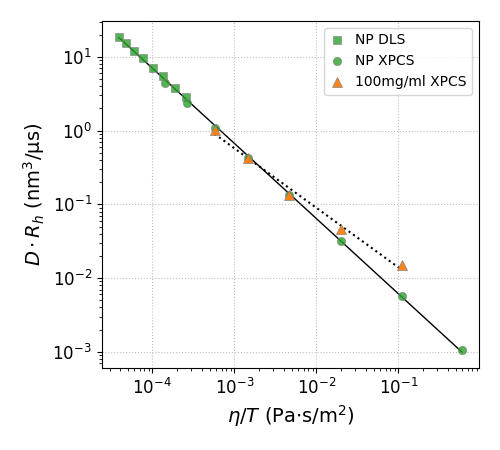

In [114]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

correct_unit = 1e21 # go from m3/s to nm3/us

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9 # m

eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12) # Ns/m2

# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

# # DLS NP100nm 23m/ol%
x_NP = np.concatenate([eta_dls/f_dls_T, f['eta_np'][1:]/f['T_np'][1:]])
y_NP = np.concatenate([f_dls_D*1e-12 * Rh_NP, SE[1:] * Rh_NP])


ax.plot(eta_dls/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit, label='NP DLS', c='C2', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=2)

SE = kb * f['T_np'] / (6*np.pi * f['eta_np'] * fact * Rh_NP)
ax.plot(f['eta_np'][1:]/f['T_np'][1:], SE[1: ] * Rh_NP * correct_unit, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=3)

popt,xc,curve,perr = fit(linear_q, np.log(x_NP), np.log(y_NP), p0=[1.,1.])#, bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)
plt.plot(np.exp(xc), np.exp(curve) * correct_unit , '-k', zorder=1, lw=1)#, label=f'{popt[0]:.3f}')

# -- xpcs c1 in 19 mol%
etas = np.array([f['eta_np'][f['T_np'] == t][0] for t in Dc1['T'] ]) #Ns/m
ax.plot(etas/Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit,  marker='^', ms=7, c='C1', ls='', mew=.5,  alpha=0.95, mec='gray', label='100mg/ml XPCS', zorder=4)


x_pr = np.concatenate([eta_dls/f_dls_T, etas/Dc1['T']])
y_pr = np.concatenate([f_dls_D*1e-12 * Rh_NP, Dc1['D']*1e-12 * Rh])

popt,xc,curve,perr = fit(linear_q, np.log(etas/Dc1['T']), np.log(Dc1['D']*1e-12 * Rh), sigma=np.log(Dc1['D']*1e-12)*0.01, p0=[1.,1.])#, bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)
plt.plot(np.exp(xc), np.exp(curve) * correct_unit, ls=':', c='k', zorder=1)#, lw=2)#, label=f'{popt[0]:.2f}, {popt[1]:.3f}')

# popt,xc,curve,perr = fit(linear_q, np.log(x_pr), np.log(y_pr), sigma=np.log(y_pr)*0.01, p0=[1.,1.])
# plt.plot(np.exp(xc), np.exp(curve), ls=':', c='r', label=f'{popt[0]:.2f}, {popt[1]:.3f}')


# -- plot settings
ax.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)")
# ax.set_xlabel("$\eta/T$ (N$\cdot$s / m$^{2}$ / K)")
ax.set_xlabel("$\eta/T$ (Pa$\cdot$s/m$^{2}$)")
ax.legend(fontsize=10, handlelength=1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/DRh_vs_etaT.png', dpi=300)

**For Anita to be happy**

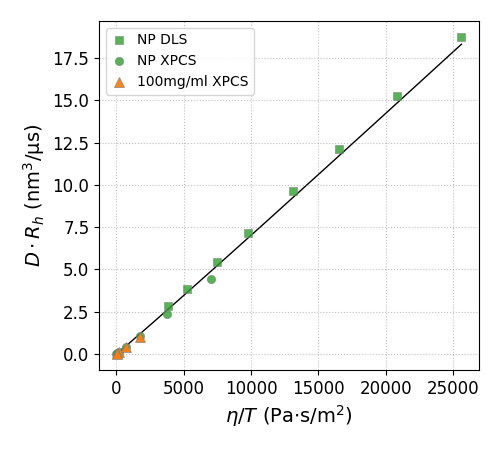

In [113]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

correct_unit = 1e21 # go from m3/s to nm3/us

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9 # m

eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12) # Ns/m2

# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

# # DLS NP100nm 23m/ol%
x_NP = np.concatenate([eta_dls/f_dls_T, f['eta_np'][1:]/f['T_np'][1:]])
y_NP = np.concatenate([f_dls_D*1e-12 * Rh_NP, SE[1:] * Rh_NP])


ax.plot(f_dls_T/eta_dls, f_dls_D*1e-12 * Rh_NP * correct_unit, label='NP DLS', c='C2', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=2)

SE = kb * f['T_np'] / (6*np.pi * f['eta_np'] * fact * Rh_NP)
ax.plot(f['T_np'][1:]/f['eta_np'][1:], SE[1: ] * Rh_NP * correct_unit, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=3)

popt,xc,curve,perr = fit(linear_q, np.log(x_NP), np.log(y_NP), p0=[1.,1.])#, bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)
plt.plot(1/np.exp(xc), np.exp(curve) * correct_unit , '-k', zorder=1, lw=1)#, label=f'{popt[0]:.3f}')

# -- xpcs c1 in 19 mol%
etas = np.array([f['eta_np'][f['T_np'] == t][0] for t in Dc1['T'] ]) #Ns/m
ax.plot(Dc1['T']/etas, Dc1['D']*1e-12 * Rh * correct_unit,  marker='^', ms=7, c='C1', ls='', mew=.5,  alpha=0.95, mec='gray', label='100mg/ml XPCS', zorder=4)


x_pr = np.concatenate([eta_dls/f_dls_T, etas/Dc1['T']])
y_pr = np.concatenate([f_dls_D*1e-12 * Rh_NP, Dc1['D']*1e-12 * Rh])

popt,xc,curve,perr = fit(linear_q, np.log(etas/Dc1['T']), np.log(Dc1['D']*1e-12 * Rh), sigma=np.log(Dc1['D']*1e-12)*0.01, p0=[1.,1.])#, bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)
# plt.plot(np.exp(xc), np.exp(curve) * correct_unit, ls=':', c='k', zorder=1)#, lw=2)#, label=f'{popt[0]:.2f}, {popt[1]:.3f}')



# -- plot settings
ax.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)")
# ax.set_xlabel("$\eta/T$ (N$\cdot$s / m$^{2}$ / K)")
ax.set_xlabel("$\eta/T$ (Pa$\cdot$s/m$^{2}$)")
ax.legend(fontsize=10, handlelength=1)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/DRh_vs_etaT.png', dpi=900)

# More work, I don't know what why where when

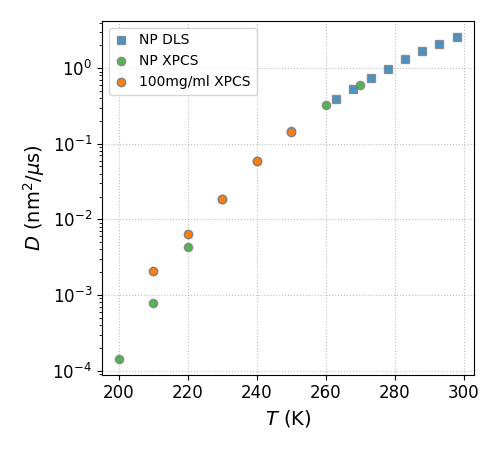

In [45]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9

# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

# DLS NP100nm 23m/ol%
ax.plot(f_dls_T, f_dls_D/Rh*Rh_NP, label='NP DLS', c='C0', mec='gray', ls='', alpha=0.8, marker='s')#, mfc='none')


SE = kb * f['T_np'] / (6*np.pi*f['eta_np']*fact*Rh)
ax.plot(f['T_np'][1:], SE[1:]*1e12, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o')
xx = np.linspace(f['T_np'][1], f['T_np'][-1], 100)
# ax.plot(xx, (SE[1:]*1e12)**0.9, label='xi=0.9', ls='', c='k', mec='k', marker='x')
# ax.plot(f['T_np'][1:], (SE[1:]*1e12)**0.9, label='xi=0.9', ls='', c='k', mec='k', marker='x')



# -- xpcs c1 in 19 mol%
D = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])
D0_np = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])

eta_xpcs = kb * Dc1['T'] / (6*np.pi * Rh *  Dc1['D'])
ax.plot(Dc1['T'], Dc1['D'],  marker='o', c='C1', ls='', mec='gray', label='100mg/ml XPCS', zorder=10)

# -- plot settings
ax.set_ylabel("$D$ (nm$^{{2}}$/${{\mu}}$s)")
ax.set_xlabel("$T$ (K)")
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/D_vs_T.png', dpi=300)

**Check units**

In [66]:
f_dls_D

array([0.05664105, 0.07665724, 0.10912588, 0.14275548, 0.19238228,
       0.24220871, 0.30496679, 0.37514384])

In [67]:
Dc1['D']

array([0.14151109, 0.05843479, 0.01832015, 0.00641778, 0.00208803])

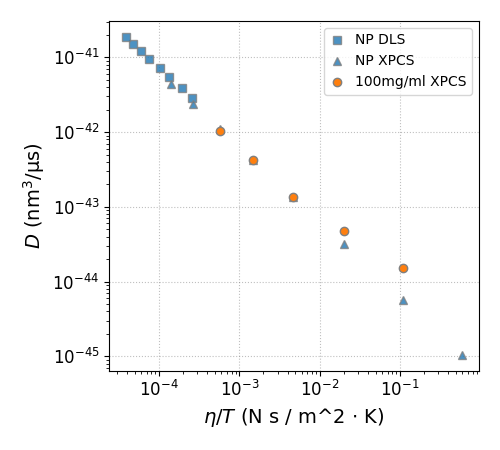

In [76]:
fig, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9


# # DLS NP100nm 23m/ol%
# eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12) # Ns/m2

ax.plot(eta_dls/f_dls_T, f_dls_D*1e-12 * Rh_NP * 1e-21, label='NP DLS', c='C0', mec='gray', ls='', alpha=0.8, marker='s')

SE = kb * f['T_np'] / (6*np.pi*f['eta_np']*fact*Rh_NP)
ax.plot(f['eta_np'][1:]/f['T_np'][1:], SE[1:] * Rh_NP * 1e-21, label='NP XPCS', ls='', c='C0', mec='gray', alpha=0.8, marker='^')

# -- xpcs c1 in 19 mol%
etas = np.array([f['eta_np'][f['T_np'] == t][0] for t in Dc1['T'] ]) #Ns/m
ax.plot(etas/Dc1['T'], Dc1['D']*1e-12 * 1e-21 * Rh,  marker='o', c='C1', ls='', mec='gray', label='100mg/ml XPCS',) # nm2/us

# -- plot settings
ax.set_ylabel("$D$ (nm$^{{3}}$/$\mathrm{\mu}$s)")
ax.set_xlabel("$\eta/T$ (N s / m^2 $\cdot$ K)")
ax.legend(fontsize=10, handlelength=1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/D_vs_T.png', dpi=900)

# Other

(200.0, 300.0)

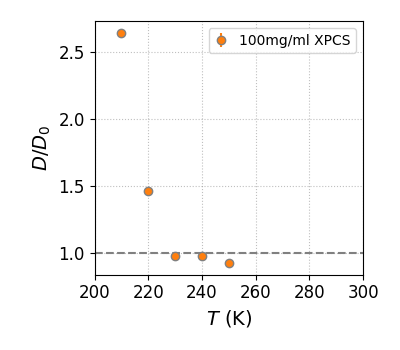

In [46]:
fig, ax = plt.subplots(1,1, figsize=(4,3.5), tight_layout=True)
cols = plt.cm.copper_r(np.linspace(0,1,3))

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m

ax.axhline(y=1, ls='--', c='gray')

# -- xpcs c1 in 19 mol%
# norm_etas_xpcs = np.array([f_19['eta_low'][f_19['T_low'] == t][0] for t in Dc1['T'] ])
# D0 = kb * Dc1['T'] / ( 6*np.pi * Rh * norm_etas_xpcs)*1e12
D = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])
D0_np = kb *f_23['T'] / (6*np.pi * Rh_NP * f_23['eta'])
# ax.plot(f_23['T'][:-8],  D[:-8]/D0_np[:-8], c='C2', ls='', marker='o', mec='gray',  label='NP XPCS')

# # DLS NP100nm 23m/ol%
# D0_np_dls = kb * f_dls_T / (6*np.pi * Rh_NP * f_23['eta'][-8:])*1e12
# # eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12)
# ax.plot(f_dls_T,  f_dls_D/D0_np_dls, marker='s', ls='', mec='gray', label='NP DLS')

norm_23 = np.array([f_23['eta'][f_23['T'] == t][0] for t in Dc1['T'] ])
D0_23 = kb * Dc1['T'] / ( 6*np.pi * Rh * norm_23 )*1e12
ax.errorbar(Dc1['T'], Dc1['D'] / D0_23, Dc1['dD'], ls='', marker='o', c='C1',  mec='gray', label='100mg/ml XPCS')


# -- plot settings
ax.set_xlabel(f'$T$ (K)')
ax.set_ylabel('$D / D_0$')
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
# ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim(200,300)
# plt.savefig('../06-figs/diff_coeff_D0_new.png', dpi=900)